# Model Hyperparameter tuning and analysis portal

We will use this notebook to:
- visualize dataset.
- find the correct model by grid search with 5-fold CV.
- save best performing model into pickle file that is ready to be deployed as API.
- visualize errors on customizable error metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## 1. Visualize dataset
Split development set and test set.  
Test set: 2020-01-01 and onward.  
Dev set: any data before 2020-01-01.

In [2]:
import sys
sys.setrecursionlimit(100000)
projectFolder = '/Users/scottj/U/hackathon/hackathon-refactored-enigma'
filename = 'dataframe2.csv'
dataset = pd.read_csv(f'{projectFolder}/data/parsed/{filename}')
dataset['Date_Time'] = pd.to_datetime(dataset['Date_Time'], format="%Y%m%d %H:%M:%S")
dataset = dataset.set_index('Date_Time')
dataset

,calgary_bow_flow(m3/s),banff_bow_flow(m3/s),elbow_precip(mm),elbow-river-bragg-creek(m3/s),elbow-river-glenmore-dam(m3/s),snow-pillow-elbow(mm),lake-louise-precip(mm),lake-louise-snow-pillow(mm)
Date_Time,,,,,,,,
2000-04-01 00:00:00,75.276250,8.217030,0.0,0.000000,4.871450,380.39999,0.0,355.23561
2000-04-01 01:00:00,75.126810,8.217150,0.0,0.000000,5.881160,381.35001,0.0,355.23561
2000-04-01 02:00:00,74.977350,8.205775,0.0,0.000000,5.985200,381.35001,0.0,355.23561
2000-04-01 03:00:00,74.677900,8.240400,0.0,0.000000,5.985250,381.35001,0.0,355.23561
2000-04-01 04:00:00,72.278450,8.275020,0.0,0.000000,5.777300,382.29999,0.0,355.23561
...,...,...,...,...,...,...,...,...
2020-09-30 19:00:00,59.615721,23.038812,0.0,5.199962,2.469573,1.60889,0.0,0.00000
2020-09-30 20:00:00,58.268692,22.992368,0.0,5.202278,2.469517,1.61096,0.0,0.00000
2020-09-30 21:00:00,57.964387,22.993643,0.0,5.192512,2.469463,1.61303,0.0,0.00000


In [3]:
X = dataset.drop(['calgary_bow_flow(m3/s)'], axis=1)
X_train = X[:'2019']
X_test = X['2020']
X_test

,banff_bow_flow(m3/s),elbow_precip(mm),elbow-river-bragg-creek(m3/s),elbow-river-glenmore-dam(m3/s),snow-pillow-elbow(mm),lake-louise-precip(mm),lake-louise-snow-pillow(mm)
Date_Time,,,,,,,
2020-04-01 00:00:00,6.500000,0.000,20.116965,2.360000,473.86391,0.2,419.53702
2020-04-01 01:00:00,6.500000,0.000,20.116965,2.360000,473.86318,0.2,419.53436
2020-04-01 02:00:00,6.500000,0.125,20.116965,2.360000,473.86246,0.2,419.53169
2020-04-01 03:00:00,6.500000,0.025,20.116965,2.360000,473.86173,0.2,419.52903
2020-04-01 04:00:00,6.500000,0.000,20.116965,2.360000,473.86100,0.2,419.52637
...,...,...,...,...,...,...,...
2020-09-30 19:00:00,23.038812,0.000,5.199962,2.469573,1.60889,0.0,0.00000
2020-09-30 20:00:00,22.992368,0.000,5.202278,2.469517,1.61096,0.0,0.00000
2020-09-30 21:00:00,22.993643,0.000,5.192512,2.469463,1.61303,0.0,0.00000


In [4]:
y_train = dataset.loc[:'2019', 'calgary_bow_flow(m3/s)']
y_test = dataset.loc['2020', 'calgary_bow_flow(m3/s)']
y_test

Date_Time
2020-04-01 00:00:00    128.158951
2020-04-01 01:00:00    128.158951
2020-04-01 02:00:00    128.158951
2020-04-01 03:00:00    128.158951
2020-04-01 04:00:00    128.158951
                          ...    
2020-09-30 19:00:00     59.615721
2020-09-30 20:00:00     58.268692
2020-09-30 21:00:00     57.964387
2020-09-30 22:00:00     57.660082
2020-09-30 23:00:00     57.077983
Name: calgary_bow_flow(m3/s), Length: 4392, dtype: float64

## 2. Find best model
### 2.1 Search for best algorithm

EN: 0.684178 (0.170545)
KNN: 0.265960 (0.431375)
RF: 0.431530 (0.336962)


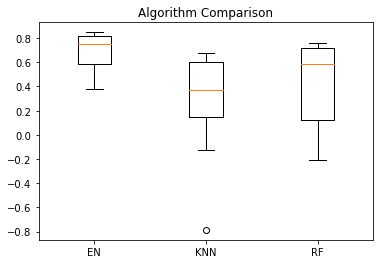

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
# from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR

models = []
models.append(('EN', ElasticNet()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
# models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

### 2.2 ElasticNet grid search with CV

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

regressor = ElasticNet()
param_search = { 
    'alpha': [1, 10, 20, 30],
    'normalize': [True, False],
    'fit_intercept': [True, False],
    'max_iter':[100, 200, 1000]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=regressor, cv=tscv, param_grid=param_search, scoring='r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_parameters = gsearch.best_params_
best_model = gsearch.best_estimator_

print(best_score)
print(best_parameters)
print(best_model)

0.7061784230491253
{'alpha': 20, 'fit_intercept': True, 'max_iter': 100, 'normalize': False}
ElasticNet(alpha=20, max_iter=100)


In [7]:
# save the model to disk
filename = './model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

### 2.3 Predict

In [8]:
from sklearn.metrics import mean_squared_error
print("Train-set volume R^2: {:.2f}".format(best_model.score(X_train, y_train)))
print("Test-set volume R^2: {:.2f}".format(best_model.score(X_test, y_test)))
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)
print("Train-set volume RMSE: {:.2f}".format(mean_squared_error(y_train, 
                                                         y_pred_train, 
                                                        squared=False)))
print("Test-set volume RMSE: {:.2f}".format(mean_squared_error(y_test, 
                                                        y_pred,
                                                       squared=False)))

Train-set volume R^2: 0.85
Test-set volume R^2: 0.82
Train-set volume RMSE: 31.08
Test-set volume RMSE: 31.58


### 2.4 Visualization

In [9]:
y_pred_df = pd.DataFrame(y_pred.reshape(4392), index=y_test.index, columns=['prediction'])

In [10]:
y_compare = pd.concat([y_test, y_pred_df], axis=1)

y_compare

,calgary_bow_flow(m3/s),prediction
Date_Time,,
2020-04-01 00:00:00,128.158951,55.419500
2020-04-01 01:00:00,128.158951,55.419538
2020-04-01 02:00:00,128.158951,55.419577
2020-04-01 03:00:00,128.158951,55.419616
2020-04-01 04:00:00,128.158951,55.419654
...,...,...
2020-09-30 19:00:00,59.615721,62.532567
2020-09-30 20:00:00,58.268692,62.484928
2020-09-30 21:00:00,57.964387,62.481825


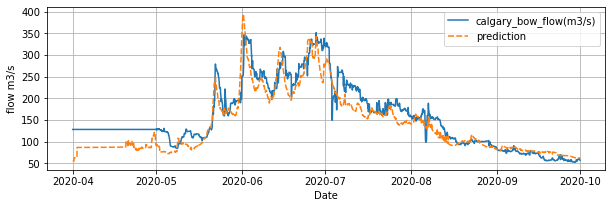

In [11]:
#prepare plotting
plt.figure(figsize=(10, 3))
sns.lineplot(data=y_compare)
plt.xlabel("Date")
plt.ylabel("flow m3/s")
plt.grid()